In [1]:
import os
import requests
import pandas as pd
from astropy.io import fits
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.optimize import minimize
from scipy.interpolate import RectBivariateSpline
import emcee
import corner
import scipy.io as sio
from ipywidgets import FloatProgress
from IPython.display import display
from scipy.integrate import trapz
import time

In [2]:
stellarCatalog = "../stellarCatalogs/dr25_stellar_supp_gaia_clean_notimeout_GKM.txt"
pcCatalog = "koiCatalogs/dr25_GKM_PCs_notimeout.csv"

period_rng = (10, 500)
n_period = 101
rp_rng = (2.5, 5)
n_rp = 101

# for quick tests
nWalkers = 25
nBurnin = 500
nMcmc = 1000
# for production runs
#nWalkers = 100
#nBurnin = 1000
#nMcmc = 2000


#model = "dualPowerLaw"
model= "brokenPowerLaw"
# which Radii lets you try with planet radii corrected for Gaia radii (whichRadii = "corrected")
# or with original KOI table planet radii (whichRadii = "kic")
whichRadii = "corrected"

In [3]:
def medianAndErrorbars(data):
    if data.ndim > 1:
        dataResult = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(data, [16, 50, 84],
                                                axis=0)))
        dataResult = list(dataResult)
        return dataResult
    else:
        v = np.percentile(data, [16, 50, 84])
        return [v[1], v[2]-v[1], v[1]-v[0]]

def printMedianAndErrorbars(data):
    e = medianAndErrorbars(data)
    if data.ndim > 1:
        print("printMedianAndErrorbars only works for 1D arrays")
    else:
        return "{:.3f}".format(e[0]) +"^{+" + "{:.3f}".format(e[1]) + "}_{-" + "{:.3f}".format(e[2]) + "}"

In [4]:
from scipy.integrate import romb

def integrate2DGrid(g, dx, dy):
    #if g.shape[0]%2 == 0 or g.shape[1]%2 == 0:
    #    raise ValueError('integrate2DGrid requires a grid with odd number of points on a side');
    return trapz(trapz(g, dx=dx), dx=dy)

def integrateRateModel(periodRange, rpRange, theta, model):
    nPts = 5
    pGrid, rGrid = np.meshgrid(np.linspace(start=periodRange[0], stop=periodRange[1], num=nPts), 
                                np.linspace(start=rpRange[0], stop=rpRange[1], num=nPts), indexing="ij")
    dp = (pGrid[1,0]-pGrid[0,0])
    dr = (rGrid[0,1]-rGrid[0,0])
    
    if theta.ndim == 1:
        y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta, model)
        return integrate2DGrid(y, dp, dr)
    else: # assume first dimension is array of thetas
        ret = np.zeros(theta.shape[0])
        if len(ret) > 100:
            f = FloatProgress(min=0, max=len(ret))
            display(f)

        for i in range(len(ret)):
            y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta[i,:], model)
            ret[i] = integrate2DGrid(y, dp, dr)
            if len(ret) > 100:
                f.value += 1
        return ret

def integratePopTimesComp(periodRange, rpRange, theta, model, compGrid):
    nP = compGrid.shape[0]
    nR = compGrid.shape[1]

    pGrid, rGrid = np.meshgrid(np.linspace(periodRange[0], periodRange[1], nP), 
                                       np.linspace(rpRange[0], rpRange[1], nR), 
                                       indexing="ij")
    dp = (pGrid[1,0]-pGrid[0,0])
    dr = (rGrid[0,1]-rGrid[0,0])
    y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta, model)*compGrid
    return integrate2DGrid(y, dp, dr)

In [5]:
# population inference functions
def lnlike(theta):
    pop = rateModel(period_grid, rp_grid, period_rng, rp_rng, theta, model) * summedCompleteness
    pop = 0.5 * (pop[:-1, :-1] + pop[1:, 1:])
    norm = np.sum(pop * vol)
    ll = np.sum(np.log(rateModel(koi_periods, koi_rps, period_rng, rp_rng, theta, model))) - norm
    return ll if np.isfinite(ll) else -np.inf

# The ln-probability function is just propotional to the ln-likelihood
# since we're assuming uniform priors.
def lnprob(theta):
    lp = lnPoisprior(theta, model)
    if not np.isfinite(lp):
        return -np.inf

    return lnlike(theta)

# The negative ln-likelihood is useful for optimization.
# Optimizers want to *minimize* your function.
def nll(theta):
    ll = lnlike(theta)
    return -ll if np.isfinite(ll) else 1e15

In [6]:
def getRadii(catalog):
    if whichRadii == "corrected":
        return catalog.corrected_prad
    elif whichRadii == "kic":
        return catalog.koi_prad
    else:
        raise ValueError('Bad whichRadii string')

In [7]:
stellarTargets = pd.read_csv(stellarCatalog)
base_kois = pd.read_csv(pcCatalog)
m = (period_rng[0] <= base_kois.koi_period) & (base_kois.koi_period <= period_rng[1])
thisRadii = getRadii(base_kois)
m &= np.isfinite(thisRadii) & (rp_rng[0] <= thisRadii) & (thisRadii <= rp_rng[1])
    
kois = pd.DataFrame(base_kois[m])
allKois = kois

In [8]:
#period = np.linspace(period_rng[0], period_rng[1], num=5)
#rp = np.linspace(rp_rng[0], rp_rng[1], num=5)
#period_grid, rp_grid = np.meshgrid(period, rp, indexing="ij")
#periodShape = period_grid.shape

period = np.logspace(np.log10(10), np.log10(500), num=5)
rp = np.logspace(np.log10(2.5), np.log10(5), num=5)
period_grid, rp_grid = np.meshgrid(period, rp, indexing="ij")
periodShape = period_grid.shape

In [9]:
inputgrid = "../completenessContours/out0603_sc0_GKM_baseline.fits.gz"

hdulist = fits.open(inputgrid)
cumulative_array = hdulist[0].data
kiclist = np.asarray(hdulist[1].data, dtype=np.int32)
probdet = np.transpose(cumulative_array[0])
probtot = np.transpose(cumulative_array[1])
prihdr = hdulist[0].header
min_comp_period = prihdr["MINPER"]
max_comp_period = prihdr["MAXPER"]
n_comp_period = prihdr["NPER"]
min_comp_rp = prihdr["MINRP"]
max_comp_rp = prihdr["MAXRP"]
n_comp_rp = prihdr["NRP"]
# print "KIC list length" + '{:6d}'.format(kiclist.size)
print(hdulist[0].header,)

period_want = np.linspace(min_comp_period, max_comp_period, n_comp_period)
rp_want = np.linspace(min_comp_rp, max_comp_rp, n_comp_rp)
period_want2d, rp_want2d = np.meshgrid(period_want, rp_want)

numCompVeInterp = RectBivariateSpline(period_want, rp_want, probtot)
numProbDetInterp = RectBivariateSpline(period_want, rp_want, probdet)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                 1000                                                  NAXIS2  =                 1000                                                  NAXIS3  =                    2                                                  EXTEND  =                    T                                                  MINPER  =                 10.0                                                  MAXPER  =                500.0                                                  NPER    =                 1000                                                  MINRP   =                  2.5                                                  MAXRP   =                  6.0                                                  NRP     =                 1000          

In [10]:
summedCompleteness = numCompVeInterp(period, rp)
summedProbDet = numProbDetInterp(period, rp)

In [11]:
print(summedCompleteness.shape)
print(summedProbDet.shape)

(5, 5)
(5, 5)


In [12]:
# population analysis functions modified from Daniel Foreman Mackey's https://dfm.io/posts/exopop/

# We'll reuse these functions to plot all of our results.
def make_plot(pop_comp, x0, x, y, ax ,q):
    
    pop = 0.5*(pop_comp[:, 1:] + pop_comp[:, :-1])
    pop = np.sum(pop * np.diff(y)[None, :, None], axis=1)
    
    x = np.append(np.diff(x), q)
    
    a, b, c, d, e = np.percentile(pop * x, [2.5, 16, 50, 84, 97.5], axis=0)
    #print("in make_plot, pop_comp:")
    #print(pop_comp.shape)

    #pop = 0.5 * (pop_comp[:, 1:] + pop_comp[:, :-1])
    #print("pop:")
    #print(pop.shape)
    #pop = np.sum(pop * np.diff(y)[None, :, None], axis=1)
    #print(pop.shape)
    #a, b, c, d, e = np.percentile(pop * np.diff(x)[0], [2.5, 16, 50, 84, 97.5], axis=0)
    #print(c.shape)
    
    ax.fill_between(x0, a, e, color="k", alpha=0.1, edgecolor="none")
    ax.fill_between(x0, b, d, color="k", alpha=0.3, edgecolor="none")
    ax.plot(x0, c, "k", lw=1)

def plot_results(samples):
    #  Loop through the samples and compute the list of population models.
    samples = np.atleast_2d(samples)
    pop = np.empty((len(samples), period_grid.shape[0], period_grid.shape[1]))
    gamma_earth = np.empty((len(samples)))

    for i, p in enumerate(samples):
        pop[i] = rateModel(period_grid, rp_grid, period_rng, rp_rng, p, model)
        gamma_earth[i] = rateModel(365.25, 1.0, period_rng, rp_rng, p, model) * 365.
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    
    # Integrate over period.
    dx = 0.25
    x = rp.copy()
    n, _ = np.histogram(koi_rps, x)
    
    fsize = 18
    # Plot the observed radius distribution.
    ax = axes[0, 0]
    make_plot(pop * summedCompleteness[None, :, :], rp, x, period, ax, q=0.94603558)
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    #ax.set_xlim(rp_rng[0], rp_rng[1])
    ax.set_xlabel("$R_p\,[R_\oplus]$", fontsize = fsize)
    ax.set_ylabel("# of detected planets", fontsize = fsize)
    
    # Plot the true radius distribution.
    ax = axes[0, 1]
    make_plot(pop, rp, x, period, ax, q=0.94603558)
    #ax.set_xlim(rp_rng[0], rp_rng[1])
    #ax.set_ylim(0, 0.37)
    ax.set_xlabel("$R_p\,[R_\oplus]$", fontsize = fsize)
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}R$; $\Delta R = 0.25\,R_\oplus$", fontsize = fsize)
    
    # Integrate over period.
    dx = 31.25
    x = period.copy()
    n, _ = np.histogram(koi_periods, x)
    
    # Plot the observed period distribution.
    ax = axes[1, 0]
    make_plot(np.swapaxes(pop * summedCompleteness[None, :, :], 1, 2), period, x, rp, ax, q=829.57397424)
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    #ax.set_xlim(period_rng[0], period_rng[1])
    #ax.set_ylim(0, 79)
    ax.set_xlabel("$P\,[\mathrm{days}]$", fontsize = fsize)
    ax.set_ylabel("# of detected planets", fontsize = fsize)
    
    # Plot the true period distribution.
    ax = axes[1, 1]
    make_plot(np.swapaxes(pop, 1, 2), period, x, rp, ax, q=829.57397424)
    #ax.set_xlim(period_rng[0], period_rng[1])
    #ax.set_ylim(0, 0.27)
    ax.set_xlabel("$P\,[\mathrm{days}]$", fontsize = fsize)
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}P$; $\Delta P = 31.25\,\mathrm{days}$", fontsize = fsize)
    
                
    return gamma_earth, fig

In [13]:
def rateModel(x, y, xRange, yRange, theta, model):
    if model == "dualPowerLaw":
        f0, alpha, beta = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1))    
    elif model == "crazy shit":
        f0, a, b, c, alpha = theta
        ap1 = alpha+1
        r = f0*(ap1*(y**alpha)/(yRange[1]**ap1-yRange[0]**ap1))*((a*x + (b/x) + c)/(0.5*a*(xRange[1]**2-xRange[0]**2) + b*np.log(xRange[1]/xRange[0]) + c*(xRange[1]-xRange[0])))
    elif model == "brokenPowerLaw":
        f0, alpha, beta, delta, xb = theta
        ap1 = alpha+1
        bp1 = beta+1
        dt1 = delta+1
        if np.isscalar(x) == True:
            xArray = np.asarray([x]);
            yArray = np.asarray([y]);
        else:
            xArray = x;
            yArray = y;
        
        rx = np.zeros(np.shape(xArray))
        x1 = np.where(xArray < xb)
        x2 = np.where(xArray >= xb)
        #print(type(x))
        rx[x1] = bp1*(xArray[x1]**beta) / (xb**bp1 - xRange[0]**bp1)
        rx[x2] = dt1*(xArray[x2]**delta) / (xRange[1]**dt1 - xb**dt1)
        
        ry = (ap1*(yArray**alpha)/(yRange[1]**ap1-yRange[0]**ap1))
        r = f0*rx*ry
    else:
        raise ValueError('Bad model name');      
    return r

def getModelLabels(model):
    if model == "dualPowerLaw":
        return [r"$F_0$", r"$\beta$", r"$\alpha$"]
    elif model == "crazy shit":
        return ["f0", "a", "b", "c", r"$\alpha$"]
    elif model == "brokenPowerLaw":
        return ["f0", r"$\alpha$", r"$\beta$", r"$\delta$", "Xb"]
    else:
        raise ValueError('Bad model name');

def initRateModel(model):
    if model == "dualPowerLaw":
        f0 = 1
        alpha = 1
        beta = 1
        theta = [f0, alpha, beta]
    elif model == "crazy shit":
        f0 = 1
        a = 1
        b = 1
        c = 1
        alpha = 1
        theta = [f0, a, b, c, alpha]
    elif model == "brokenPowerLaw":
        f0 = 0.75
        alpha = -1
        beta = 0.5
        delta = 0.5
        xb = 100;
        theta = [f0, alpha, beta, delta, xb];
    else:
        raise ValueError('Bad model name');
  
    return theta

def lnPoisprior(theta, model):
    if model == "dualPowerLaw":
        if 0.0 <= theta[0] <= 5 \
        and -5.0 <= theta[1] <= 5.0 \
        and -10.0 <= theta[2] <= 10.0:
            return 1.0
    elif model == "crazy shit":
        if 0.0 <= theta[0] <= 5 \
        and -5.0 <= theta[1] <= 5.0 \
        and -5.0 <= theta[2] <= 10.0 \
        and -5.0 <= theta[3] <= 5.0 \
        and -5.0 <= theta[4] <= 5.0:
            return 1.0
        
    elif model == "brokenPowerLaw":
        if 0.0 <= theta[0] <= 5 \
        and -6.0 <= theta[1] <= 5.0 \
        and -5.0 <= theta[2] <= 10.0 \
        and -5.0 <= theta[3] <= 5.0 \
        and 0.0 <= theta[4] <= 300.0:
            return 1.0
    else:
        raise ValueError('Bad model name');
        
    # print(theta)
    return -np.inf

Compute a basic occurrence rate without reliability

[0.75, -1, 0.5, 0.5, 100]
1000000000000000.0
[  0.18980668  -3.49086063  -0.3467593   -3.04295626 100.82762717]


/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


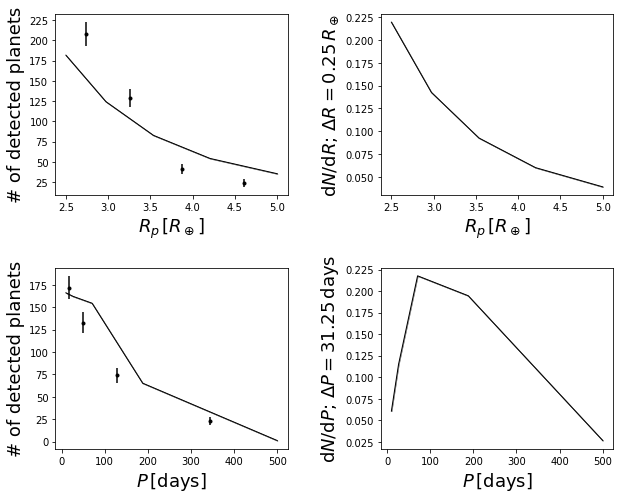

In [14]:
kois = allKois

if model == "dualPowerLaw":
    bounds = [(0, 5), (-5, 5), (-6, 5)]
elif model == "crazy shit":
    bounds = [(0, 5), (-5, 5), (-5, 10), (-5, 5), (-5, 5)]
elif model == "brokenPowerLaw":
    bounds = [(0, 5), (-6, 5), (-5, 10), (-5, 5), (0, 300)]
    
# The ln-likelihood function given at the top of this post.
koi_periods = np.array(kois.koi_period)
koi_rps = np.array(getRadii(kois))
# koi_rps = getRadii(kois)

vol = np.diff(period_grid, axis=0)[:, :-1] * np.diff(rp_grid, axis=1)[:-1, :]

theta_0 = initRateModel(model)
#theta_0 = [5, 1, 5]
print(theta_0)
print(nll(theta_0))
r = minimize(nll, theta_0, method="L-BFGS-B", bounds=bounds)
print(r.x)
ge, fig = plot_results(r.x)
#[ 0.88074391 -0.50150404  0.11076642]

In [15]:

##################################################################
ndim, nwalkers = len(r.x), nWalkers
pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=8)

# Burn in.
pos, _, _ = sampler.run_mcmc(pos, nBurnin)
sampler.reset()

# Production.
start_time = time.time()
pos, _, _ = sampler.run_mcmc(pos, nMcmc)
print("--- %s seconds ---" % (time.time() - start_time))

samples_noreliability = sampler.flatchain

--- 3.5132012367248535 seconds ---


18.885389596341795


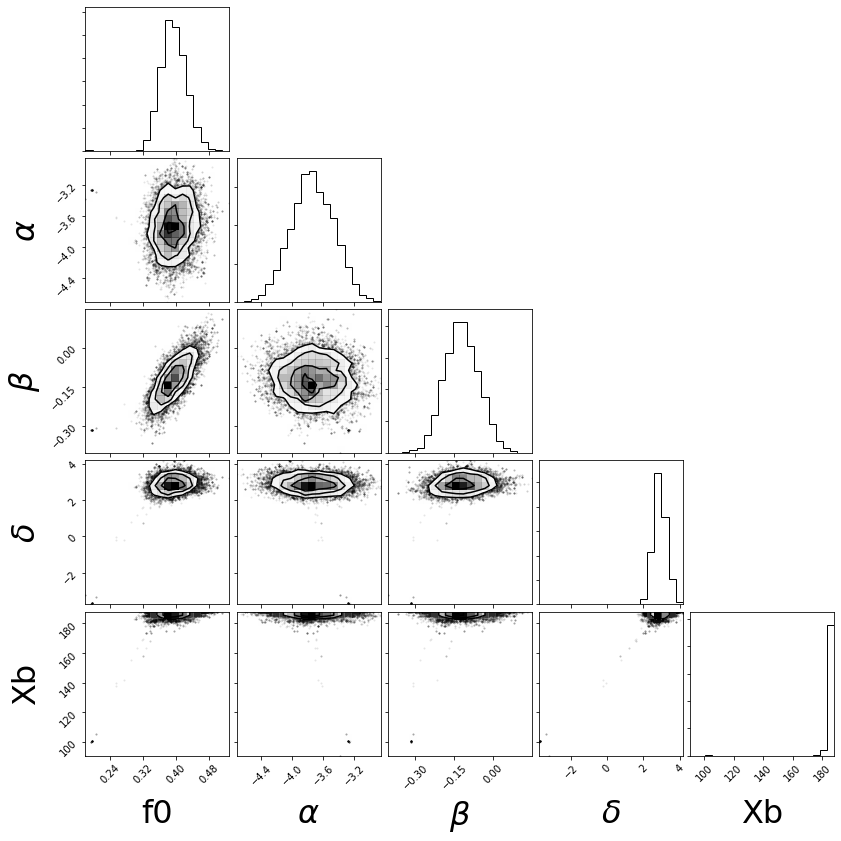

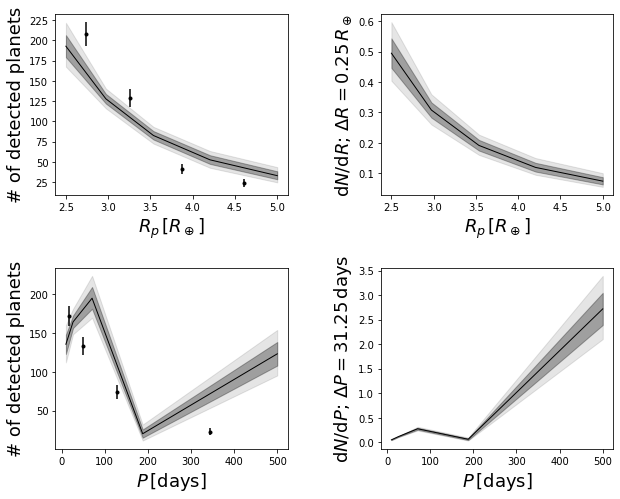

In [16]:
##################################################################
##################################################################

corner.corner(samples_noreliability, labels=getModelLabels(model), label_kwargs = {"fontsize": 32})
#plt.savefig("occPostNoReliability.pdf",bbox_inches='tight')

##################################################################

gamma_earth_no_reliability, fig = plot_results(samples_noreliability)
#plt.savefig("occMargNoReliability.pdf",bbox_inches='tight')
print(np.mean(gamma_earth_no_reliability))

##################################################################

Compute an occurrence rate with reliability

In [17]:
nTrials = 100

f = FloatProgress(min=0, max=nTrials)
display(f)

allKois = kois
for mCount in range(nTrials):
    # randomly select kois
    
    koiSelect = (np.random.rand(len(allKois)) < allKois.totalReliability)
#    koiSelect = (np.random.rand(len(allKois)) < allKois.reliability)
    kois = allKois[koiSelect]
#    kois.to_csv("occurenceRatePosteriors/selectedPcs" + str  (mCount) + ".csv")
#    print(str(mCount) + " of " + str(nTrials) + ", selected " + str(len(kois)) 
#          + " kois out of " + str(len(allKois)) + " after reliability cut")
    
    koi_periods = np.array(kois.koi_period)
    koi_rps = np.array(getRadii(kois))

    theta_0 = initRateModel(model)
    r = minimize(nll, theta_0, method="L-BFGS-B", bounds=bounds)

    ##################################################################

    ndim, nwalkers = len(r.x), 2*len(r.x)
    pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

    # Burn in.
    pos, _, _ = sampler.run_mcmc(pos, 200)
    sampler.reset()

    # Production.
    pos, _, _ = sampler.run_mcmc(pos, 1000)

    samples = sampler.flatchain   
    if mCount == 0:
        allSamples = samples[0:-1:10,:]
    else:
        allSamples = np.concatenate((allSamples, samples[0:-1:10,:]))
    
    f.value += 1

FloatProgress(value=0.0)

/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars
/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars


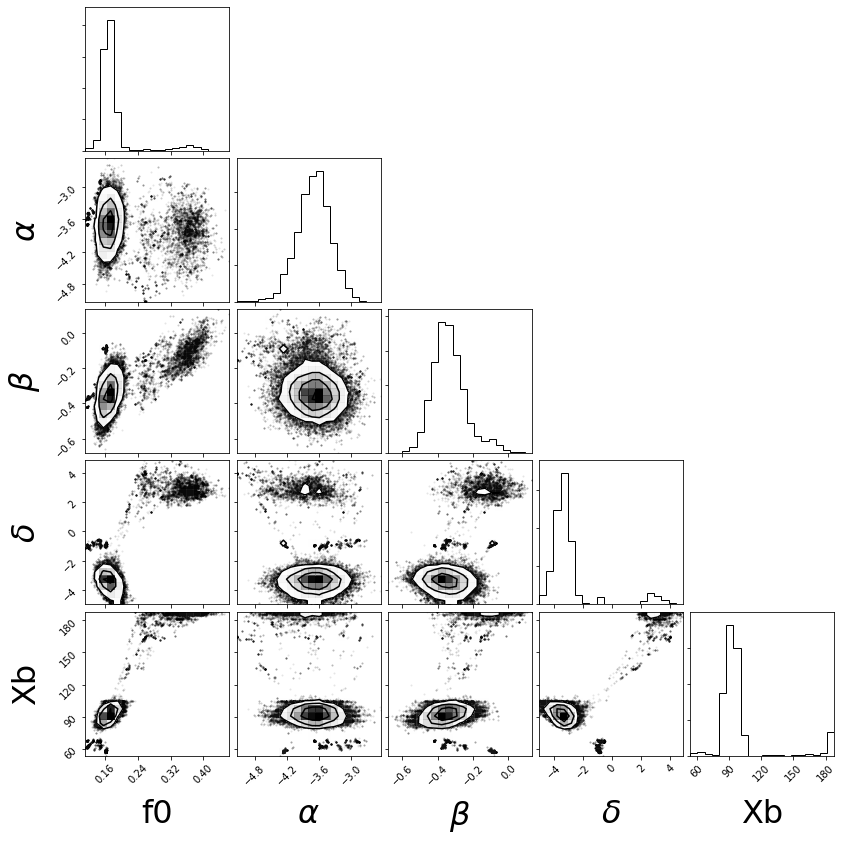

In [18]:
corner.corner(allSamples, labels=getModelLabels(model), label_kwargs = {"fontsize": 32});
#plt.savefig("occPostReliability.pdf",bbox_inches='tight')

In [19]:
modelLabels = getModelLabels(model)
for i in range(0,ndim):
    print("MCMC no reliability " + modelLabels[i] + "=" + printMedianAndErrorbars(samples_noreliability[:,i]))
for i in range(0,ndim):
    print("MCMC with reliability " + modelLabels[i] + "=" + printMedianAndErrorbars(allSamples[:,i]))

MCMC no reliability f0=0.392^{+0.032}_{-0.029}
MCMC no reliability $\alpha$=-3.737^{+0.286}_{-0.275}
MCMC no reliability $\beta$=-0.121^{+0.067}_{-0.066}
MCMC no reliability $\delta$=2.882^{+0.380}_{-0.330}
MCMC no reliability Xb=187.652^{+0.288}_{-2.213}
MCMC with reliability f0=0.169^{+0.017}_{-0.013}
MCMC with reliability $\alpha$=-3.691^{+0.288}_{-0.318}
MCMC with reliability $\beta$=-0.345^{+0.095}_{-0.079}
MCMC with reliability $\delta$=-3.320^{+0.630}_{-0.564}
MCMC with reliability Xb=92.189^{+7.909}_{-5.596}


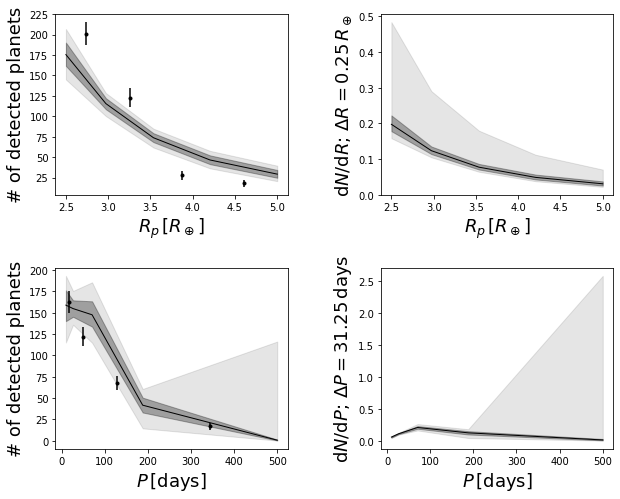

In [20]:
gamma_earth, fig = plot_results(allSamples)
#plt.savefig("occMargReliability.png", bbox_inches='tight')

In [21]:
p_cent = 0.5* (period[1:] + period[:-1])
r_cent = 0.5* (rp[1:] + rp[:-1])

In [22]:
a = np.linspace(np.log10(10), np.log10(500), num=10)
b = np.diff(np.linspace(np.log10(10), np.log10(500), num=10))
print(a)
c = 10**np.append(a, a[-1]+b[0])
print(a, b, c)

d = np.diff(c)
print(d)

#plt.plot(d, [1, 1, 1, 1, 1], 'o')
#plt.xscale('log')

[1.         1.18877444 1.37754889 1.56632333 1.75509778 1.94387222
 2.13264667 2.32142111 2.51019556 2.69897   ]
[1.         1.18877444 1.37754889 1.56632333 1.75509778 1.94387222
 2.13264667 2.32142111 2.51019556 2.69897   ] [0.18877444 0.18877444 0.18877444 0.18877444 0.18877444 0.18877444
 0.18877444 0.18877444 0.18877444] [ 10.          15.44452105  23.85332304  36.84031499  56.89810203
  87.87639344 135.72088083 209.61440008 323.73940143 500.
 772.22605247]
[  5.44452105   8.408802    12.98699194  20.05778704  30.97829142
  47.84448739  73.89351925 114.12500135 176.26059857 272.22605247]


In [23]:
a = np.linspace(np.log10(2.5), np.log10(5), num=10)
b = np.diff(np.linspace(np.log10(2.5), np.log10(5), num=10))
print(a)
c = 10**np.append(a, a[-1]+b[0])
print(a, b, c)

d = np.diff(c)
print(d)

#plt.plot(d, [1, 1, 1, 1, 1], 'o')
#plt.xscale('log')

[0.39794001 0.43138779 0.46483556 0.49828334 0.53173112 0.5651789
 0.59862667 0.63207445 0.66552223 0.69897   ]
[0.39794001 0.43138779 0.46483556 0.49828334 0.53173112 0.5651789
 0.59862667 0.63207445 0.66552223 0.69897   ] [0.03344778 0.03344778 0.03344778 0.03344778 0.03344778 0.03344778
 0.03344778 0.03344778 0.03344778] [2.5        2.70014935 2.9163226  3.14980262 3.401975   3.67433623
 3.96850263 4.28621991 4.62937356 5.         5.40029869]
[0.20014935 0.21617325 0.23348003 0.25217238 0.27236123 0.2941664
 0.31771728 0.34315365 0.37062644 0.40029869]


In [24]:
def dfm(pg, rg, prng, rrng, pbins, rbins, samples, model, comp, cplt=False):
    samples = np.atleast_2d(samples)
    pop = np.empty((len(samples), pg.shape[0], pg.shape[1]))
    for i, p in enumerate(samples):
        pop[i] = rateModel(pg, rg, prng, rrng, p, model)
    #pop = rateModel(pg, rg, prng, rrng, sample, model)
    if cplt:
        pop = pop * comp[None, :, :]
        alt_pop = np.swapaxes(pop, 1, 2)
    else:
        #pop = pop[None, :, :]
        alt_pop = np.swapaxes(pop, 1, 2)
    
    pop = 0.5*(pop[:, 1:] + pop[:, :-1])
    pop = np.sum(pop * np.diff(pbins)[None, :, None], axis=1)
    
    alt_pop = 0.5*(alt_pop[:, 1:] + alt_pop[:, :-1])
    alt_pop = np.sum(alt_pop * np.diff(rbins)[None, :, None], axis=1)
    
    x = np.append(np.diff(rbins), 0.94603558)
    y = np.append(np.diff(pbins), 829.57397424)
    
    r = np.percentile(pop * x, [2.5, 16, 50, 84, 97.5], axis=0)
    p = np.percentile(alt_pop * y, [2.5, 16, 50, 84, 97.5], axis=0)
    
    return(r, p)

def recreate(pg, rg, prng, rrng, pbins, rbins, samples, model, comp, cplt=False):
    samples = np.atleast_2d(samples)
    pop = np.empty((len(samples), pg.shape[0], pg.shape[1]))
    for i, p in enumerate(samples):
        pop[i] = rateModel(pg, rg, prng, rrng, p, model)
    #pop = rateModel(pg, rg, prng, rrng, sample, model)
    if cplt:
        pop = pop * comp[None, :, :]
        alt_pop = np.swapaxes(pop, 1, 2)
    else:
        #pop = pop[None, :, :]
        alt_pop = np.swapaxes(pop, 1, 2)
    
    pop = trapz(pop, x=pbins, axis=1)
    alt_pop = trapz(alt_pop, x=rbins, axis=1)
    
    x = np.append(np.diff(rbins), 0.94603558)
    y = np.append(np.diff(pbins), 829.57397424)
    
    r = np.percentile(pop * x, [2.5, 16, 50, 84, 97.5], axis=0)
    p = np.percentile(alt_pop * y, [2.5, 16, 50, 84, 97.5], axis=0)
    return(r, p)

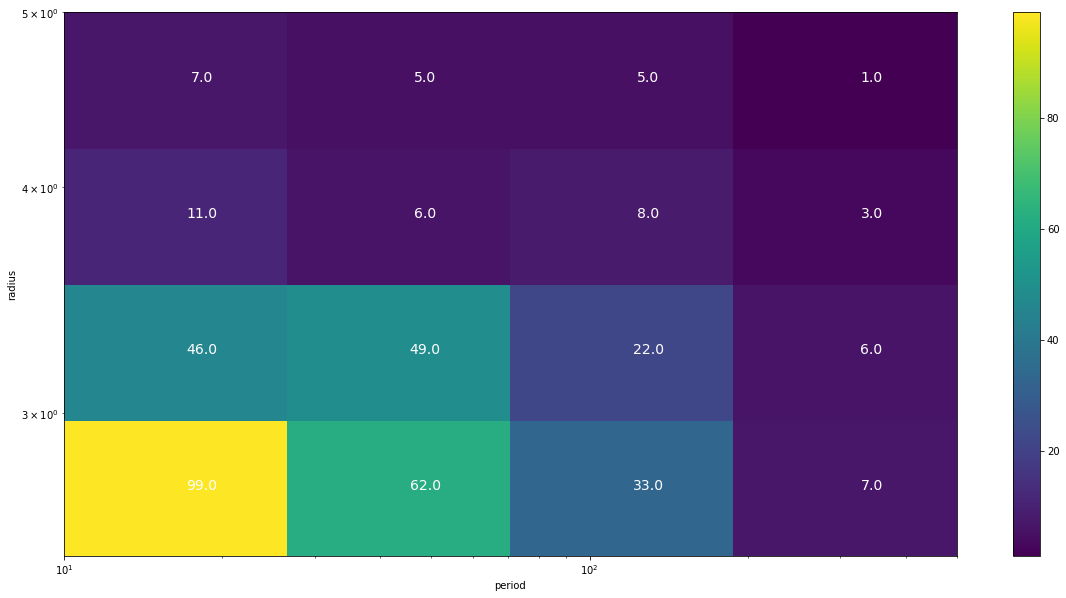

In [25]:
H, xedges, yedges = np.histogram2d(kois.koi_period, getRadii(kois), bins=(period, rp))
xcent = 0.5 * (xedges[1:] + xedges[:-1])
ycent = 0.5 * (yedges[1:] + yedges[:-1])

#X, Y = np.meshgrid(xedges, yedges)
fig, ax = plt.subplots(figsize=(20, 10))
#ax = fig.add_subplot(132)
im = ax.pcolormesh(period_grid, rp_grid, H)

for i in range(len(yedges)-1):
    for j in range(len(xedges)-1):
        ax.text(xcent[j],ycent[i], H.T[i,j], 
                color="white", ha="center", va="center", fontsize=14)

#plt.xlim(.1,500)
plt.xlabel('period')
plt.ylabel('radius')
plt.xscale('log')
plt.yscale('log')
fig.colorbar(im)
#plt.savefig("10hist_p10500r255.png")
plt.show()

In [26]:
dfm_rad, dfm_per = dfm(period_grid, rp_grid, period_rng, rp_rng, period, rp, 
                        allSamples, model, summedCompleteness)
rad, per = recreate(period_grid, rp_grid, period_rng, rp_rng, period, rp, 
                     allSamples, model, summedCompleteness)

dfm_rad_num, dfm_per_num = dfm(period_grid, rp_grid, period_rng, rp_rng, period, rp, 
                        allSamples, model, summedCompleteness, cplt=True)
rad_num, per_num = recreate(period_grid, rp_grid, period_rng, rp_rng, period, rp, 
                     allSamples, model, summedCompleteness, cplt=True)

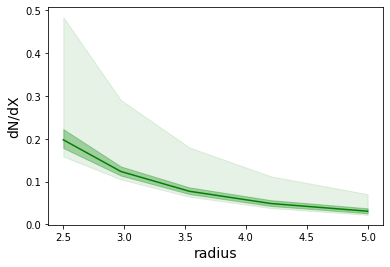

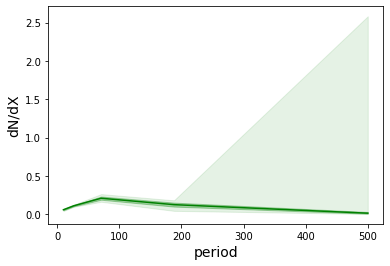

In [27]:
plt.figure()
#plt.fill_between(rp, dfm_rad[0], dfm_rad[4], color="m", alpha=0.1, edgecolor="none")
#plt.fill_between(rp, dfm_rad[1], dfm_rad[3], color="m", alpha=0.3, edgecolor="none")
#plt.plot(rp, dfm_rad[2], label='dfm, radius', linestyle='--', color='m')
plt.fill_between(rp, rad[0], rad[4], color="g", alpha=0.1, edgecolor="none")
plt.fill_between(rp, rad[1], rad[3], color="g", alpha=0.3, edgecolor="none")
plt.plot(rp, rad[2], color='g', label='mine, radius')
#plt.legend()
plt.ylabel("dN/dX", fontsize=14)
plt.xlabel("radius", fontsize=14)

plt.figure()
#plt.fill_between(period, dfm_per[0], dfm_per[4], color="m", alpha=0.1, edgecolor="none")
#plt.fill_between(period, dfm_per[1], dfm_per[3], color="m", alpha=0.3, edgecolor="none")
#plt.plot(period, dfm_per[2], label='dfm, period', linestyle='--', color='m')
plt.fill_between(period, per[0], per[4], color="g", alpha=0.1, edgecolor="none")
plt.fill_between(period, per[1], per[3], color="g", alpha=0.3, edgecolor="none")
plt.plot(period, per[2], color='g', label='mine, period')
#plt.legend()
plt.ylabel("dN/dX", fontsize=14)
plt.xlabel("period", fontsize=14)

plt.show()

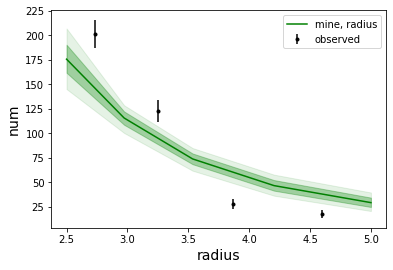

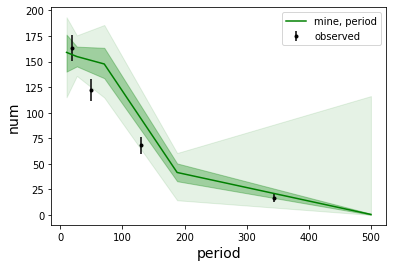

In [28]:
plt.figure()
#plt.fill_between(rp, dfm_rad_num[0], dfm_rad_num[4], color="m", alpha=0.1, edgecolor="none")
#plt.fill_between(rp, dfm_rad_num[1], dfm_rad_num[3], color="m", alpha=0.3, edgecolor="none")
#plt.plot(rp, dfm_rad_num[2], label='dfm, radius', linestyle='--', color='m')
plt.fill_between(rp, rad_num[0], rad_num[4], color="g", alpha=0.1, edgecolor="none")
plt.fill_between(rp, rad_num[1], rad_num[3], color="g", alpha=0.3, edgecolor="none")
plt.plot(rp, rad_num[2], color='g', label='mine, radius')

plt.errorbar(r_cent, np.sum(H, axis=0), yerr=np.sqrt(np.sum(H, axis=0)), fmt=".k", label='observed')

plt.legend()
plt.ylabel("num", fontsize=14)
plt.xlabel("radius", fontsize=14)

plt.figure()
#plt.fill_between(period, dfm_per_num[0], dfm_per_num[4], color="m", alpha=0.1, edgecolor="none")
#plt.fill_between(period, dfm_per_num[1], dfm_per_num[3], color="m", alpha=0.3, edgecolor="none")
#plt.plot(period, dfm_per_num[2], label='dfm, period', linestyle='--', color='m')
plt.fill_between(period, per_num[0], per_num[4], color="g", alpha=0.1, edgecolor="none")
plt.fill_between(period, per_num[1], per_num[3], color="g", alpha=0.3, edgecolor="none")
plt.plot(period, per_num[2], color='g', label='mine, period')

plt.errorbar(p_cent, np.sum(H, axis=1), yerr=np.sqrt(np.sum(H, axis=1)), fmt=".k", label='observed')

plt.legend()
plt.ylabel("num", fontsize=14)
plt.xlabel("period", fontsize=14)

plt.show()

In [29]:
from scipy.interpolate import griddata
points = np.array(list(zip(period_grid.flatten(), rp_grid.flatten())))
values = summedCompleteness.flatten()

pc = np.array(list(zip(kois.koi_period.values, getRadii(kois).values)))

grid = griddata(points, values, pc, method='linear')
#print(grid)

In [30]:
kois['completeness'] = grid/ kiclist.size
kois['kois_rp'] = getRadii(kois)

/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [31]:
occ = np.zeros((len(period)-1, len(rp)-1))

for i in range(len(period)-1):
    for j in range(len(rp)-1):
        #print(i, j)
        #print([period[i], period[i+1]], [rp[j], rp[j+1]])
        bin_ = kois[((kois.koi_period < period[i+1]) & (kois.koi_period > period[i]) & 
                     (kois.kois_rp < rp[j+1]) & (kois.kois_rp > rp[j]))]
        occ[i, j] = np.sum(bin_.totalReliability / bin_.completeness) / kiclist.size
        
print(occ)

[[0.04522226 0.02236547 0.00510139 0.0031023 ]
 [0.05505016 0.0402097  0.00581346 0.00368445]
 [0.06190783 0.03812631 0.0133399  0.00877563]
 [0.03141744 0.02814488 0.01889307 0.00293751]]


In [32]:
b = kois[((kois.koi_period < 500.) & (kois.koi_period > 188.03015465) & 
                     (kois.kois_rp < 5) & (kois.kois_rp > 2.5))]
np.sum(b.totalReliability / b.completeness) / kiclist.size

0.08139289931866392

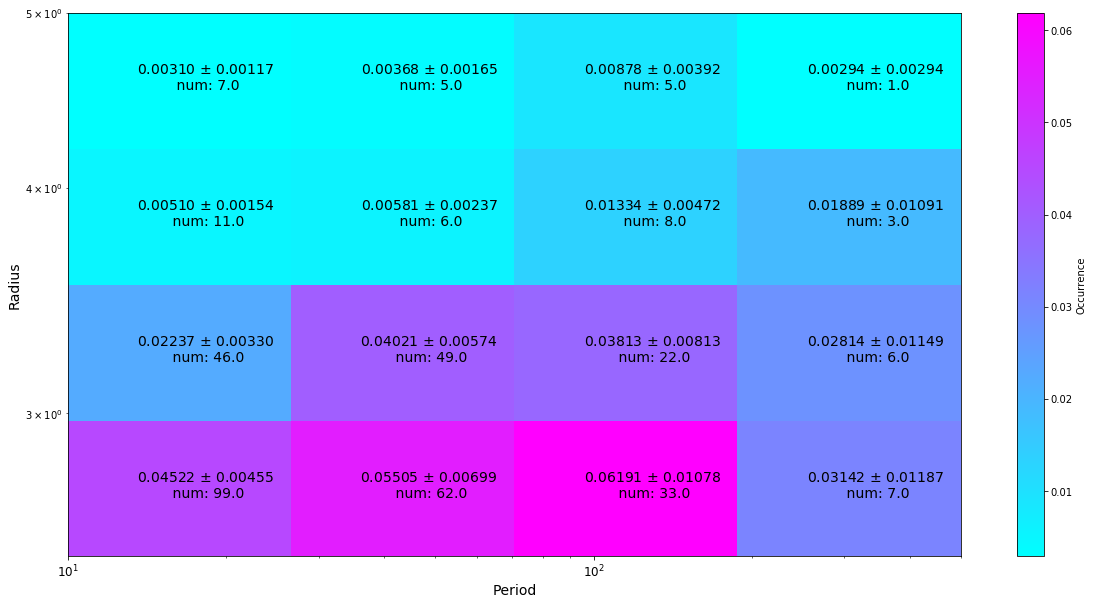

In [43]:
#offset=[2, 4, 8, 16]
exp = occ * kiclist.size
err = np.sqrt(H) * exp / (kiclist.size *H)

fig, ax = plt.subplots(figsize=(20, 10))
im = ax.pcolormesh(period_grid, rp_grid, occ, cmap='cool')
for i in range(len(yedges)-1):
    for j in range(len(xedges)-1):
        t = str("%.5f" % occ.T[i,j]) + r" $\pm$ " + str("%.5f" % err.T[i,j]) + '\n num: ' + str(H.T[i,j])
        ax.text(xcent[j], ycent[i], t, 
                color="k", ha="center", va="center", fontsize=14)

ax.tick_params(axis='both', labelsize='large')
               
plt.colorbar(im, label="Occurrence")
plt.xlabel("Period", fontsize=14)
plt.ylabel("Radius", fontsize=14)
plt.xscale('log')
plt.yscale('log')
#plt.savefig('10occhist_p10500r255.png')
plt.show()

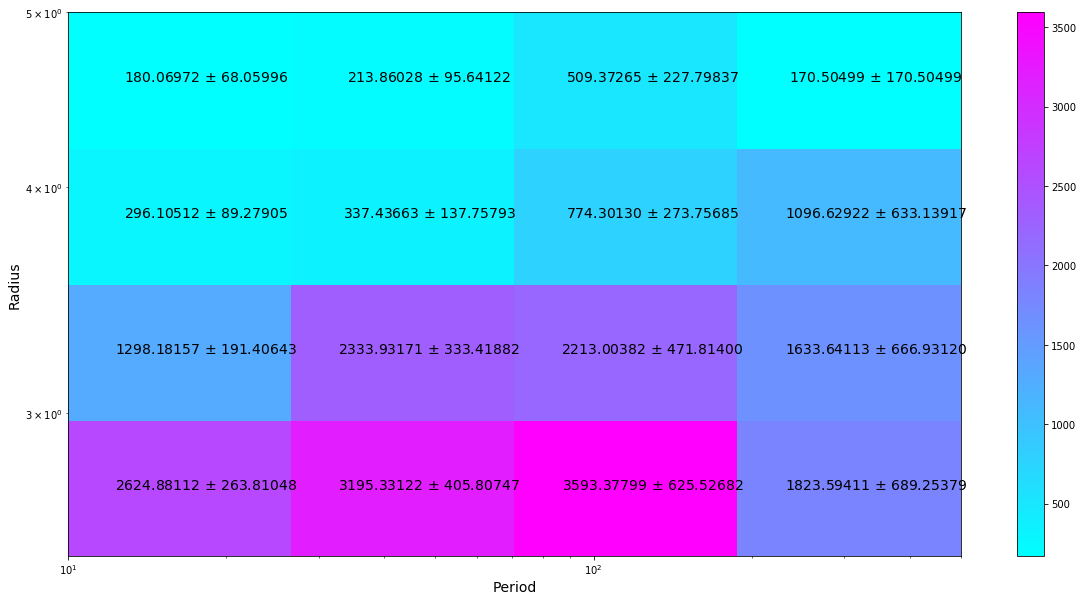

In [50]:
exp = occ * kiclist.size
exp_err = np.sqrt(H)/H * exp

fig, ax = plt.subplots(figsize=(20,10))
im = ax.pcolormesh(period_grid, rp_grid, exp, cmap='cool')
for i in range(len(yedges)-1):
    for j in range(len(xedges)-1):
        t = str("%.5f" % exp.T[i,j]) + r" $\pm$ " + str("%.5f" % exp_err.T[i,j])
        ax.text(xcent[j], ycent[i], t, 
                color="k", ha="center", va="center", fontsize=14)

plt.colorbar(im)
plt.xlabel("Period", fontsize=14)
plt.ylabel("Radius", fontsize=14)
plt.xscale('log')
plt.yscale('log')
#plt.savefig('10occhist_p10500r255.png')
plt.show()

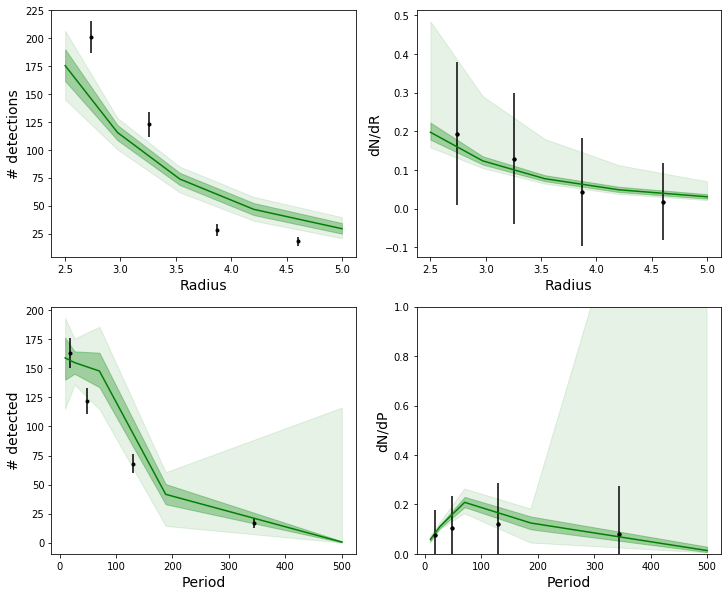

In [53]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

#axs[0, 0].fill_between(rp, dfm_rad_num[0], dfm_rad_num[4], color="m", alpha=0.1, edgecolor="none")
#axs[0, 0].fill_between(rp, dfm_rad_num[1], dfm_rad_num[3], color="m", alpha=0.3, edgecolor="none")
#axs[0, 0].plot(rp, dfm_rad_num[2], label='dfm, radius', linestyle='--', color='m')
axs[0, 0].fill_between(rp, rad_num[0], rad_num[4], color="g", alpha=0.1, edgecolor="none")
axs[0, 0].fill_between(rp, rad_num[1], rad_num[3], color="g", alpha=0.3, edgecolor="none")
axs[0, 0].plot(rp, rad_num[2], color='g', label='mine, radius')
axs[0, 0].errorbar(r_cent, np.sum(H, axis=0), yerr=np.sqrt(np.sum(H, axis=0)), fmt=".k", label='observed')
axs[0, 0].set_xlabel('Radius', fontsize=14)
axs[0, 0].set_ylabel('# detections', fontsize=14)
#axs[0,0].legend()

#axs[0, 1].fill_between(rp, dfm_rad[0], dfm_rad[4], color="m", alpha=0.1, edgecolor="none")
#axs[0, 1].fill_between(rp, dfm_rad[1], dfm_rad[3], color="m", alpha=0.3, edgecolor="none")
#axs[0, 1].plot(rp, dfm_rad[2], label='dfm, radius', linestyle='--', color='m')
axs[0, 1].fill_between(rp, rad[0], rad[4], color="g", alpha=0.1, edgecolor="none")
axs[0, 1].fill_between(rp, rad[1], rad[3], color="g", alpha=0.3, edgecolor="none")
axs[0, 1].plot(rp, rad[2], color='g', label='mine, radius')
axs[0, 1].scatter(r_cent, np.sum(occ, axis=0), marker='.', color='k')
axs[0, 1].errorbar(r_cent, np.sum(occ, axis=0), yerr=np.sqrt(np.sum(err, axis=0)), fmt=".k", label='observed')
axs[0, 1].set_xlabel('Radius', fontsize=14)
axs[0, 1].set_ylabel('dN/dR', fontsize=14)
#axs[0,1].legend()

#axs[1, 1].fill_between(period, dfm_per[0], dfm_per[4], color="m", alpha=0.1, edgecolor="none")
#axs[1, 1].fill_between(period, dfm_per[1], dfm_per[3], color="m", alpha=0.3, edgecolor="none")
#axs[1, 1].plot(period, dfm_per[2], label='dfm, period', linestyle='--', color='m')
axs[1, 1].fill_between(period, per[0], per[4], color="g", alpha=0.1, edgecolor="none")
axs[1, 1].fill_between(period, per[1], per[3], color="g", alpha=0.3, edgecolor="none")
axs[1, 1].plot(period, per[2], color='g', label='mine, period')
axs[1, 1].scatter(p_cent, np.sum(occ, axis=1), marker='.', color='k')
axs[1, 1].errorbar(p_cent, np.sum(occ, axis=1), yerr=np.sqrt(np.sum(err, axis=1)), fmt=".k", label='observed')
axs[1, 1].set_xlabel('Period', fontsize=14)
axs[1, 1].set_ylabel('dN/dP', fontsize=14)
axs[1, 1].set_ylim(0,1)
#axs[1,1].legend()

#axs[1,0].fill_between(period, dfm_per_num[0], dfm_per_num[4], color="m", alpha=0.1, edgecolor="none")
#axs[1,0].fill_between(period, dfm_per_num[1], dfm_per_num[3], color="m", alpha=0.3, edgecolor="none")
#axs[1,0].plot(period, dfm_per_num[2], label='dfm, period', linestyle='--', color='m')
axs[1,0].fill_between(period, per_num[0], per_num[4], color="g", alpha=0.1, edgecolor="none")
axs[1,0].fill_between(period, per_num[1], per_num[3], color="g", alpha=0.3, edgecolor="none")
axs[1,0].plot(period, per_num[2], color='g', label='mine, period')
axs[1,0].errorbar(p_cent, np.sum(H, axis=1), yerr=np.sqrt(np.sum(H, axis=1)), fmt=".k", label='observed')
axs[1,0].set_xlabel('Period', fontsize=14)
axs[1,0].set_ylabel('# detected', fontsize=14)
#axs[1,0].legend()

plt.show()

In [54]:
cut_rad_o1, cut_per_o1 = recreate(period_grid[:2, :], rp_grid[:2, :], period_rng, rp_rng, period[:2], rp, 
                                 allSamples, model, summedCompleteness[:2, :])
cut_rad_o2, cut_per_o2 = recreate(period_grid[1:3, :], rp_grid[1:3, :], period_rng, rp_rng, period[1:3], rp, 
                                 allSamples, model, summedCompleteness[1:3, :])
cut_rad_o3, cut_per_o3 = recreate(period_grid[2:4, :], rp_grid[2:4, :], period_rng, rp_rng, period[2:4], rp, 
                                 allSamples, model, summedCompleteness[2:4, :])
cut_rad_o4, cut_per_o4 = recreate(period_grid[3:, :], rp_grid[3:, :], period_rng, rp_rng, period[3:], rp, 
                                 allSamples, model, summedCompleteness[3:, :])

In [55]:
period

array([ 10.        ,  26.59147948,  70.71067812, 188.03015465,
       500.        ])

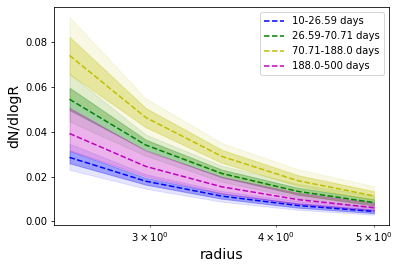

In [59]:
plt.figure()
plt.fill_between(rp, cut_rad_o1[0], cut_rad_o1[4], color="b", alpha=0.1, edgecolor="none")
plt.fill_between(rp, cut_rad_o1[1], cut_rad_o1[3], color="b", alpha=0.3, edgecolor="none")
plt.plot(rp, cut_rad_o1[2], label='10-26.59 days', linestyle='--', color='b')

plt.fill_between(rp, cut_rad_o2[0], cut_rad_o2[4], color="g", alpha=0.1, edgecolor="none")
plt.fill_between(rp, cut_rad_o2[1], cut_rad_o2[3], color="g", alpha=0.3, edgecolor="none")
plt.plot(rp, cut_rad_o2[2], label='26.59-70.71 days', linestyle='--', color='g')

plt.fill_between(rp, cut_rad_o3[0], cut_rad_o3[4], color="y", alpha=0.1, edgecolor="none")
plt.fill_between(rp, cut_rad_o3[1], cut_rad_o3[3], color="y", alpha=0.3, edgecolor="none")
plt.plot(rp, cut_rad_o3[2], label='70.71-188.0 days', linestyle='--', color='y')

#plt.fill_between(rp, cut_rad_o4[0], cut_rad_o4[4], color="m", alpha=0.1, edgecolor="none")
plt.fill_between(rp, cut_rad_o4[1], cut_rad_o4[3], color="m", alpha=0.3, edgecolor="none")
plt.plot(rp, cut_rad_o4[2], label='188.0-500 days', linestyle='--', color='m')

plt.legend()
plt.ylabel("dN/dlogR", fontsize=14)
plt.xlabel("radius", fontsize=14)
plt.xscale('log')

plt.show()

In [36]:
exp = np.zeros((len(period)-1, len(rp)-1))

for i in range(len(period)-1):
    for j in range(len(rp)-1):
        #print(i, j)
        #print([period[i], period[i+1]], [rp[j], rp[j+1]])
        exp[i, j] = integratePopTimesComp([period[i], period[i+1]], [rp[j], rp[j+1]], 
                                          np.median(allSamples, 0), model, summedCompleteness[i:i+2, j:j+2])
        
print(exp)

[[47.88042959 30.34704113 19.09784431 11.98921594]
 [45.84596607 29.63759671 18.80544043 11.84005661]
 [34.88021166 23.33364593 15.05189854  9.54112822]
 [ 8.90827649  6.35784555  4.25390881  2.74433382]]


In [37]:
print("period axis")
print(np.sum(H, axis=1))
print(np.sum(exp, axis=1))

print("radius axis")
print(np.sum(H, axis=0))
print(np.sum(exp, axis=0))

period axis
[163. 122.  68.  17.]
[109.31453097 106.12905983  82.80688435  22.26436467]
radius axis
[201. 123.  28.  18.]
[137.51488382  89.67612932  57.20909209  36.11473459]


(4, 4) (4, 4)


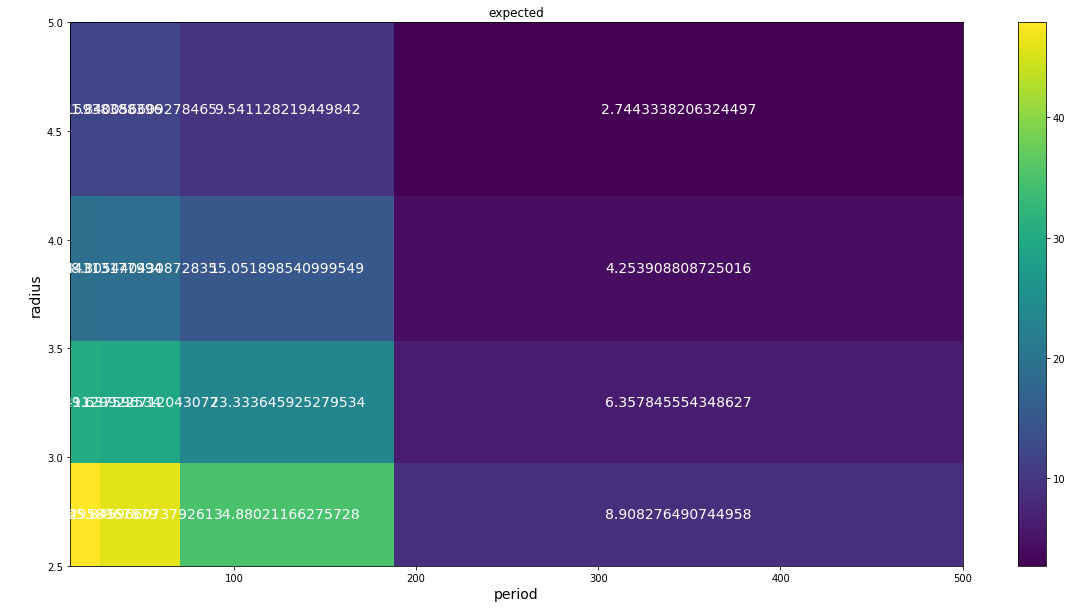

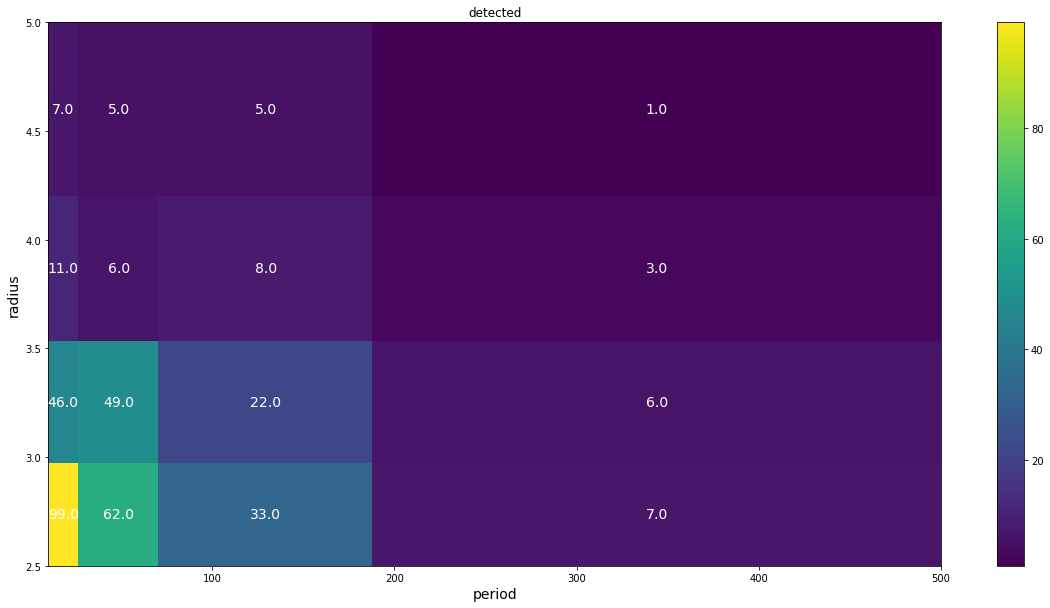

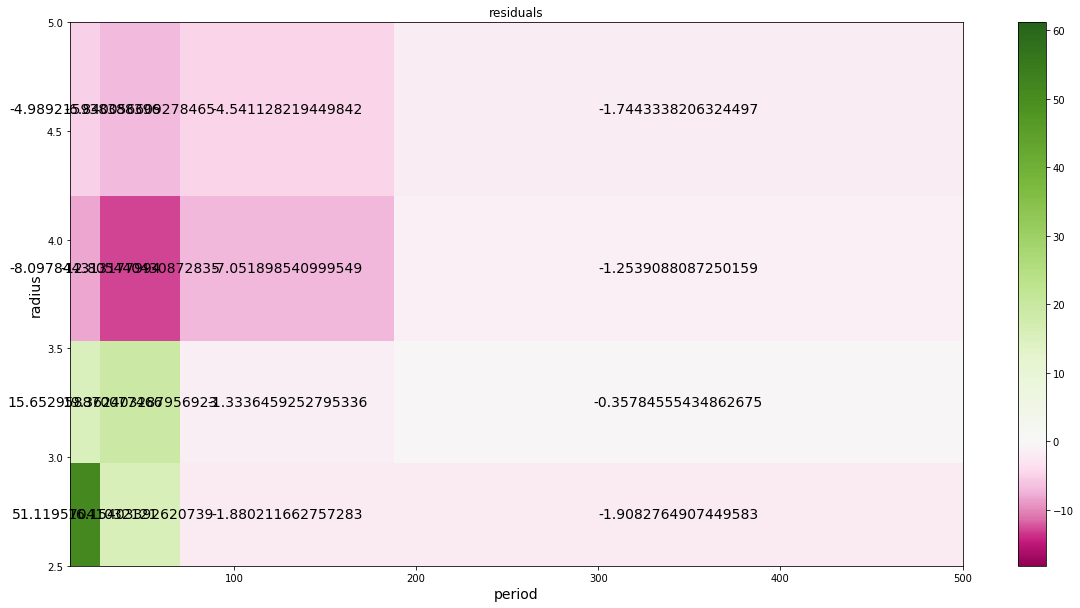

In [38]:
fig, ax = plt.subplots(figsize=(20, 10))
#ax = fig.add_subplot(132)
im = ax.pcolormesh(period_grid, rp_grid, exp)

for i in range(len(yedges)-1):
    for j in range(len(xedges)-1):
        ax.text(xcent[j],ycent[i], exp.T[i,j], 
                color="white", ha="center", va="center", fontsize=14)

plt.xlabel('period', fontsize=14)
plt.ylabel('radius', fontsize=14)
fig.colorbar(im)
plt.title("expected")

fig, ax = plt.subplots(figsize=(20, 10))
#ax = fig.add_subplot(132)
im = ax.pcolormesh(period_grid, rp_grid, H)

for i in range(len(yedges)-1):
    for j in range(len(xedges)-1):
        ax.text(xcent[j],ycent[i], H.T[i,j], 
                color="white", ha="center", va="center", fontsize=14)

plt.xlabel('period', fontsize=14)
plt.ylabel('radius', fontsize=14)
fig.colorbar(im)
plt.title('detected')
print(H.shape, exp.shape)

fig, ax = plt.subplots(figsize=(20, 10))
#ax = fig.add_subplot(132)
from matplotlib import colors
divnorm = colors.DivergingNorm(vmin=min((H-exp)[0])-10, vcenter=0., vmax=max((H-exp)[0])+10)
im = ax.pcolormesh(period_grid, rp_grid, H-exp, cmap='PiYG', norm=divnorm)

for i in range(len(yedges)-1):
    for j in range(len(xedges)-1):
        ax.text(xcent[j],ycent[i], (H-exp).T[i,j], 
                color="k", ha="center", va="center", fontsize=14)

plt.xlabel('period', fontsize=14)
plt.ylabel('radius', fontsize=14)
fig.colorbar(im)
plt.title('residuals')
plt.show()